In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [19]:
dfEnGedi = df[df.Site_Name=='En Gedi']
dfEnGedi = function.remove_unique_one(dfEnGedi)
dfEnGedi = dfEnGedi.drop(dfEnGedi.filter(regex='Season').columns, axis=1)
dfEnGedi = dfEnGedi.drop(dfEnGedi.filter(regex='Exceeded').columns, axis=1)
dfEnGedi = dfEnGedi.drop(dfEnGedi.filter(regex='isHeatwave').columns, axis=1)
dfEnGedi = dfEnGedi.replace({True:1,False:0})

In [20]:
dfEnGediWithoutLastYearVisits = dfEnGedi.drop('last_year_visitors',axis=1)
dfEnGediLastYearVisits = dfEnGedi.dropna()

In [21]:
print(dfEnGediLastYearVisits.shape)
print(dfEnGediWithoutLastYearVisits.shape)

(1002, 8)
(1381, 7)


In [22]:
dfEnGediWithoutLastYearVisits

,Date,Israelis_Count,is_weekend,pm10,IsHoliday,IsVacation,Temperature
24383,2016-01-01,44,1,8.0,0,0,13.9
24384,2016-01-02,187,1,23.5,0,0,13.6
24385,2016-01-03,356,0,45.7,0,0,14.8
24386,2016-01-04,1034,0,28.9,0,0,17.5
24387,2016-01-05,515,0,95.8,0,0,19.7
...,...,...,...,...,...,...,...
25759,2019-12-27,177,1,3.8,1,1,15.2
25760,2019-12-28,990,1,23.7,1,1,12.8
25761,2019-12-29,1938,0,22.2,1,1,19.5
25762,2019-12-30,1539,0,39.0,1,1,19.3


In [41]:
def mlrModelResTrainTestCoeff(dataframe,shaffle=False):
    dataframe.sort_values('Date')
    y = dataframe[['Date','Israelis_Count']]
    X = dataframe.drop('Israelis_Count',axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shaffle, test_size = 0.3, random_state=312148513)

    X_train_scaler = MinMaxScaler()
    X_test_scaler = MinMaxScaler()

    X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
    X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
    
    mlr = linear_model.LinearRegression()
    mlr.fit(X_train_scaled,y_train.Israelis_Count)
    
    prediction = mlr.predict(X_train_scaled)
    resTrain =  pd.DataFrame(
        data={
            'Prediction':prediction,
            'Actual': y_train.Israelis_Count.values    },
        index=y_train.Date
    )
    
    prediction = mlr.predict(X_test_scaled)
    resTest = pd.DataFrame(
        data={
            'Prediction':prediction,
            'Actual': y_test.Israelis_Count.values    },
        index=y_test.Date
    )
    coef = sorted( list(zip(np.round(mlr.coef_,5).T,X_train.drop("Date",axis=1).columns)))
    d = {}
    for tup in coef:
        d[tup[-1]] = tup[0]
    coefDF = pd.DataFrame.from_dict(d,orient='index')
    
    return resTrain,resTest,coefDF
    
def printRes(res ,plotLine=True ,plotResiduals = False):
    res = res.sort_index()
    print('rmse',function.get_rmse(res.Prediction, res.Actual))
    print('std',np.std(res.Actual))
    
    if plotResiduals:
        function.plot_residuals(actual=y_train.Israelis_Count,prediction=prediction)
    if plotLine:
        function.plot_line(actual=res.Actual,prediction=res.Prediction)
        
    print('Sample rows:')
    return res.sample(10)

In [32]:
resTrain,resTest,coeffDf = mlrModelResTrainTestCoeff(dfEnGediLastYearVisits)


In [37]:
coeffDf

,0
Temperature,-517.36502
IsVacation,-193.38898
is_weekend,-64.19112
pm10,380.34988
IsHoliday,584.85986
last_year_visitors,628.41262


rmse 649.3210878720921
std 705.4448886243786


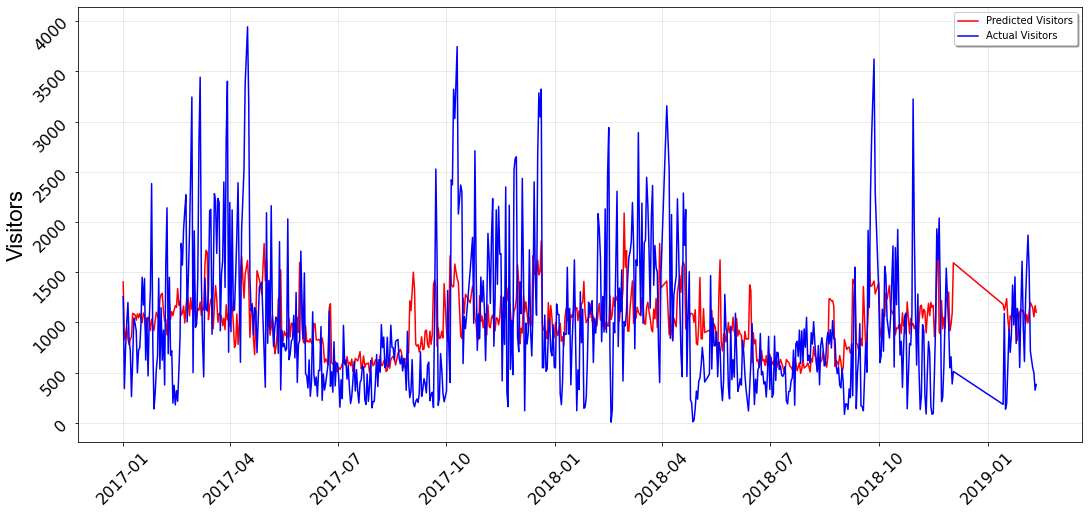

Sample rows:


,Prediction,Actual
Date,,
2018-06-21,626.830640,533
2017-02-06,1029.276146,1584
2017-11-22,1218.672807,162
2018-06-27,571.871733,410
2017-04-28,1280.690661,1400
2018-03-03,915.674468,1445
2017-03-31,1087.079985,704
2018-06-13,834.057783,119
2017-05-24,986.465336,835


In [42]:
printRes(resTrain)

rmse 688.4387155968184
std 733.4418003602834


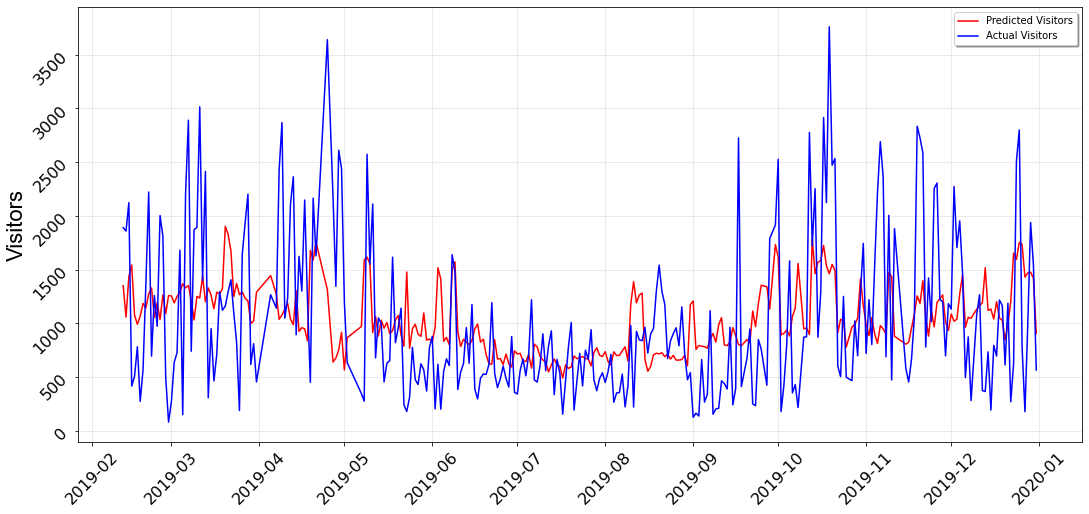

Sample rows:


,Prediction,Actual
Date,,
2019-02-17,991.043674,782
2019-11-11,879.508215,1881
2019-10-14,1461.029890,2253
2019-07-30,703.507512,485
2019-06-07,798.211168,607
2019-06-23,847.633871,535
2019-10-24,1020.327082,1250
2019-12-15,1132.553623,192
2019-11-30,932.391336,1183


In [43]:
printRes(resTest)